In [1]:
#!pip install pysrt
#!pip install pymystem3
#!pip install catboost

In [2]:
#!pip install spacy

In [3]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import glob
import os

import pysrt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy

import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df = pd.read_excel('movies_labels.xlsx')

In [7]:
df

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


In [8]:
df = df.rename(columns={'Movie': 'movie', 'Level': 'level'})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      241 non-null    int64 
 1   movie   241 non-null    object
 2   level   241 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.8+ KB


In [10]:
df['movie'].value_counts()

Powder(1995)                 2
The_terminal(2004)           2
The_blind_side(2009)         2
Inside_out(2015)             2
10_Cloverfield_lane(2016)    1
                            ..
The_hangover(2009)           1
The_holiday(2006)            1
The_invisible_man(2020)      1
The_jungle_book(2016)        1
The Grinch                   1
Name: movie, Length: 237, dtype: int64

B2            101
B1             55
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      5
Name: level, dtype: int64

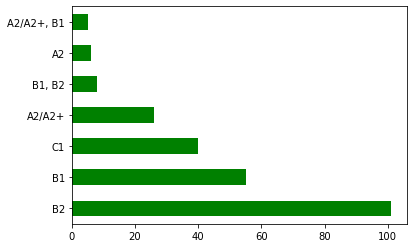

In [11]:
display(df['level'].value_counts())
df['level'].value_counts().plot(kind='barh', color='g');

На диаграмме видно, что необходимо корректно изменить категории, разделив фильмы из смежных категорий по основным уровням знания языка.

In [12]:
df['level'] = df['level'].replace('A2/A2+, B1', 'B1')
df['level'] = df['level'].replace('A2/A2+', 'B1')
df['level'] = df['level'].replace('B1, B2', 'C1')

B2    101
B1     86
C1     48
A2      6
Name: level, dtype: int64

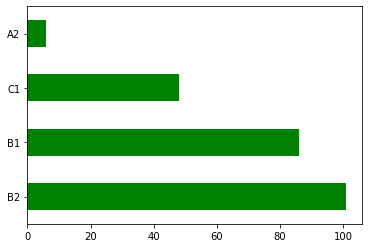

In [13]:
display(df['level'].value_counts())
df['level'].value_counts().plot(kind='barh', color='g');

In [14]:
# проверим фрейм на дубликаты
df[df['movie'].duplicated()]

,id,movie,level
44,44,Inside_out(2015),B1
68,68,Powder(1995),B1
84,84,The_blind_side(2009),B1
99,99,The_terminal(2004),B1


In [15]:
# удалим найденные дубли
df = df.drop_duplicates(subset = 'movie')
df[df['movie'].duplicated()]

,id,movie,level


In [16]:
# создадим датафрейм из названий фильмов в одной колонке
# субтитров к ним в другой
# и уровня знания языка в третьей

def import_subtitles(relative_path, level): 
    films = os.listdir(path = relative_path + '/')
    sub_labels = []
    data = {}
    
    # цикл для парсинга файлов субтитров
    for label in range(len(films)):
        sub_labels = pysrt.open(relative_path + '/' + films[label], encoding = 'iso-8859-1')
        subs = []
    # цикл для добавления текстов сутбтитров без разделителей
        for sub in sub_labels:
            subs.append(sub.text_without_tags.split('\n'))
        data[films[label]] = subs

    # формируем датафрейм из названия файла с субтитрами и субтитрами    
    data = pd.DataFrame({'movie': films, 
                         'subtitles': data.values(), 
                         'level': level}) 
    
    # удаление расширения файла из выдачи
    data['movie'] = [i[:-4] for i in data['movie']] 
    
    return data

In [17]:
# протестируем работу нашей функции

import_subtitles('Subtitles_all/C1', 'C1')

,movie,subtitles,level
0,Downton Abbey - S01E01 - Episode 1.eng.SDH,"[[[TELEGRAPH MACHINE BEEPING]], [[TRAIN WHISTL...",C1
1,Downton Abbey - S01E02 - Episode 2.eng.SDH,"[[Here we are, ma'am, Crawley House.], [For go...",C1
2,Downton Abbey - S01E03 - Episode 3.eng.SDH,"[[There you are, Mr. Bates., It's in. Came thi...",C1
3,Downton Abbey - S01E04 - Episode 4.eng.SDH,"[[[HAMMERING]], [-When does it open?, -Tomorro...",C1
4,Downton Abbey - S01E05 - Episode 5.eng.SDH,"[[[GASPS]], [You made me jump.], [Daisy, what ...",C1
5,Downton Abbey - S01E06 - Episode 6.eng.SDH,"[[Last June saw Emily Davison, crushed to deat...",C1
6,Downton Abbey - S01E07 - Episode 7.eng.SDH,"[[MRS HUGHES: Hurry up girls, come on.], [Come...",C1
7,Suits S04E01 EngSub,[],C1
8,Suits S04E02 EngSub,[],C1
9,Suits S04E03 EngSub,[],C1


In [18]:
# импортируем все субтитры

a_2 = import_subtitles('Subtitles_all/A2', 'A2')
b_1 = import_subtitles('Subtitles_all/B1', 'B1')
b_2 = import_subtitles('Subtitles_all/B2', 'B2')
c_1 = import_subtitles('Subtitles_all/C1', 'C1')
subs_all = import_subtitles('Subtitles_all/Subtitles', None)

In [19]:
total_subs = pd.concat([a_2, b_1, b_2, c_1, subs_all], ignore_index = True)
total_subs

,movie,subtitles,level
0,The Walking Dead-S01E01-Days Gone Bye.English,"[[( bugs chittering )], [( brakes squeak )], [...",A2
1,The Walking Dead-S01E02-Guts.English,"[[- ( birds chirping ), - ( bugs chittering )]...",A2
2,The Walking Dead-S01E03-Tell It To The Frogs.E...,"[[( thunder rumbling )], [Merle:, That's right...",A2
3,The Walking Dead-S01E04-Vatos.English,"[[( birds chirping )], [- What?, - Nothing.], ...",A2
4,The Walking Dead-S01E05-Wildfire.English,"[[- ( walkie-talkie squawks ), - Rick: Morgan,...",A2
...,...,...,...
273,Warm_bodies(2013),"[[What am I doing, with my life?], [I'm so pal...",None
274,Westworld_scenes_of_Dr_Robert_Ford,"[[[Music]], [no one's complained], [[Music]], ...",None
275,We_are_the_Millers(2013),"[[Oh, my God...], [...it's full-on double rain...",None
276,While_You_Were_Sleeping(1995),"[[LUCY: Okay, there are two things that, I rem...",None


In [20]:
df = df.drop('id', axis=1)
df.head()

,movie,level
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),B1


In [21]:
df = df.merge(total_subs, on='movie')
df

,movie,level_x,subtitles,level_y
0,10_Cloverfield_lane(2016),B1,"[[Fixed & Synced by bozxphd. Enjoy The Flick],...",None
1,10_things_I_hate_about_you(1999),B1,"[[Hey!], [I'll be right with you.], [So, Camer...",None
2,A_knights_tale(2001),B2,"[[Resync: Xenzai[NEF], RETAIL], [Should we hel...",None
3,A_star_is_born(2018),B2,"[[- Synced and corrected by mrcjnthn -], [Ge...",None
4,Aladdin(1992),B1,"[[Oh, I come from a land, From a faraway place...",None
...,...,...,...,...
224,Suits.S03E06.720p.HDTV.x264-mSD,C1,"[[I lost Ava her company.], [I assume my deal,...",C1
225,Suits.S03E07.HDTV.x264-mSD,C1,"[[Previously on, Suits...], [It's going up, on...",C1
226,Suits.S03E08.480p.HDTV.x264-mSD,C1,"[[I get Ava Hessington acquitted,], [Darby bac...",C1
227,Suits.S03E09.480p.HDTV.x264-mSD,C1,"[[Previously on, Suits...], [I'm bonding, with...",C1


In [22]:
df = df.drop('level_y', axis=1)
df = df.rename(columns={'level_x': 'level'})

In [23]:
df

,movie,level,subtitles
0,10_Cloverfield_lane(2016),B1,"[[Fixed & Synced by bozxphd. Enjoy The Flick],..."
1,10_things_I_hate_about_you(1999),B1,"[[Hey!], [I'll be right with you.], [So, Camer..."
2,A_knights_tale(2001),B2,"[[Resync: Xenzai[NEF], RETAIL], [Should we hel..."
3,A_star_is_born(2018),B2,"[[- Synced and corrected by mrcjnthn -], [Ge..."
4,Aladdin(1992),B1,"[[Oh, I come from a land, From a faraway place..."
...,...,...,...
224,Suits.S03E06.720p.HDTV.x264-mSD,C1,"[[I lost Ava her company.], [I assume my deal,..."
225,Suits.S03E07.HDTV.x264-mSD,C1,"[[Previously on, Suits...], [It's going up, on..."
226,Suits.S03E08.480p.HDTV.x264-mSD,C1,"[[I get Ava Hessington acquitted,], [Darby bac..."
227,Suits.S03E09.480p.HDTV.x264-mSD,C1,"[[Previously on, Suits...], [I'm bonding, with..."


Добавим все субтитры

In [24]:
#path = 'Subtitles_all'
#
#def import_subs(folder):
#    sub_labels = []
#    subs = []
#    for films in glob.glob(os.path.join(path + '\\' + folder, '*.srt')): # 'Subtitles'
#        sub_labels.append(films)
#        for i in range(len(sub_labels)):
#            subs.append(pysrt.open(sub_labels[i], encoding = 'iso-8859-1').text)
#    return subs

In [25]:
## импортируем субтитры
#a_2 = import_subs('A2')
#b_1 = import_subs('B1')
#b_2 = import_subs('B2')
#c_1 = import_subs('C1')
#subtitles_all = import_subs('Subtitles_all')

In [26]:
# создадим функции для очистки текста

stop_words = stopwords.words('english')
# тест
nlp = spacy.load("en_core_web_sm")

del_n = re.compile('\n')                # перенос каретки
del_tags = re.compile('<[^>]*>')        # html-теги
del_brackets = re.compile('\([^)]*\)')  # содержимое круглых скобок
clean_text = re.compile('[^а-яa-z\s]')  # все небуквенные символы кроме пробелов
del_spaces = re.compile('\s{2,}')       # пробелы от 2-ух подряд

def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)

def del_stopwords(text):
    clean_tokens = tuple(
        map(lambda x: x if x not in stop_words else '', word_tokenize(text))
    )
    res_text = ' '.join(clean_tokens)
    return res_text

def lemmatize(text):    
    lemmatized_text = ''.join(Mystem().lemmatize(text))
    return lemmatized_text.split('|')

In [27]:
def clean_subs(sub_list):
    filtered = []
    for word in tqdm(range(len(sub_list))):
        text = prepare_text(sub_list[word])
        text = del_stopwords(text)
        text = lemmatize(text)
        # тест
#        text = nlp(text)
        filtered.append(text)
    return filtered

In [28]:
#a_2 = clean_subs(a_2)
#b_1 = clean_subs(b_1)
#b_2 = clean_subs(b_2)
#c_1 = clean_subs(c_1)
#subs_all = clean_subs(subtitles_all)

In [29]:
df['subtitles'] = clean_subs(df['subtitles'])

100%|██████████| 229/229 [02:35<00:00,  1.47it/s]


In [30]:
df

,movie,level,subtitles
0,10_Cloverfield_lane(2016),B1,[fixed synced bozxphd enjoy flick ben phone...
1,10_things_I_hate_about_you(1999),B1,[hey ill right cameron go nine schools ...
2,A_knights_tale(2001),B2,[resync xenzainef retail help hes due lis...
3,A_star_is_born(2018),B2,[synced corrected mrcjnthn get x black eye...
4,Aladdin(1992),B1,[oh come land faraway place caravan cam...
...,...,...,...
224,Suits.S03E06.720p.HDTV.x264-mSD,C1,[ lost ava company assume deal edward dea...
225,Suits.S03E07.HDTV.x264-mSD,C1,[previously suits going wall tomorrow ...
226,Suits.S03E08.480p.HDTV.x264-mSD,C1,[ get ava hessington acquitted darby backs m...
227,Suits.S03E09.480p.HDTV.x264-mSD,C1,[previously suits im bonding father speaki...


## Подготовим данные к созданию модели ##

In [32]:
features = df['subtitles']
target = df['level']

display(features.head())
display(target.head())

0    [fixed synced  bozxphd enjoy  flick ben  phone...
1    [hey ill  right    cameron   go nine schools  ...
2    [resync xenzainef retail   help  hes due   lis...
3    [synced  corrected  mrcjnthn get   x black eye...
4    [oh  come   land   faraway place   caravan cam...
Name: subtitles, dtype: object

0    B1
1    B1
2    B2
3    B2
4    B1
Name: level, dtype: object

In [33]:
def preprocess(text):
    # удаление символов
    document = re.sub(r'\W', ' ', str(text))
    # удаление одиноко стоящих слов
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # приведение к нижнему регистру 
    document = document.lower()
    # токенизация
    #document = nltk.word_tokenize(document,language = "english")
    # лемматизация
    spacy_results = nlp(document)
    document = ' '.join([token.lemma_ for token in spacy_results])
    return document

In [34]:
#kek = []
#for i in features:
#    kek = nlp(str(features))

In [35]:
kek = features.tqdm(apply(preprocess))

In [36]:
type(kek)

pandas.core.series.Series

In [37]:
vectorizer = CountVectorizer(stop_words = stop_words)
vectorized_subs = vectorizer.fit_transform(kek).toarray()
vectorized_subs

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
features_train, features_test, target_train, target_test = train_test_split(vectorized_subs, 
                                                                            target, test_size = 0.35, 
                                                                            random_state = 69)
pd.DataFrame(
    {
        'Sample': ['features', 'target'],
        'Train': [features_train.shape, target_train.shape],
        'Test': [features_test.shape, target_test.shape]
    })

,Sample,Train,Test
0,features,"(148, 32465)","(81, 32465)"
1,target,"(148,)","(81,)"


## Обучим модели ##

### CatBoostClf ###

In [134]:
train_pool = Pool(features_train, 
                  target_train)

test_pool = Pool(features_test, target_test) 

catboost_model = CatBoostClassifier(verbose=False,
                           iterations=79
#                           depth=[depth for depth in range(30)],
#                           min_child_samples=[mcs for mcs in range(1,36,3)]
                          )
catboost_model.fit(train_pool)

In [135]:
predict_test = catboost_model.predict(features_test)
print(f1_score(target_test, predict_test, average='weighted'))

0.7495575025443604


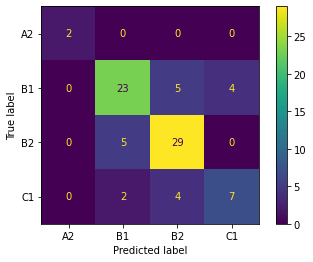

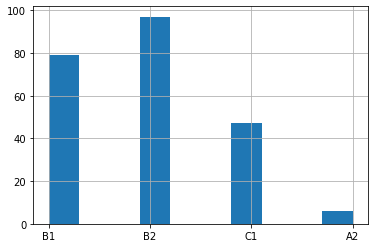

In [137]:
def conf_matrix(target, predictions, labels):
    cm = confusion_matrix(target, predictions, labels = labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=model.classes_)
    disp.plot()
    return plt.show()

conf_matrix(target_test, predict_test, catboost_model.classes_)
target.hist();

In [80]:
def search_best_estimator(pipeline, param_grid, x, y): # 
    hrs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1_weighted',
        cv=3,
#        n_candidates="exhaust",
#        factor=5,
        n_jobs=-1,
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_

In [108]:
vectorizer = TfidfVectorizer(min_df=30)
vect_x = vectorizer.fit_transform(kek)

nm = NearMiss()
X_res, Y_res = nm.fit_resample(vect_x, target)
pipeline2 = Pipeline( steps = [("base", RandomForestClassifier() )]  )
param_grid2 = {
        "base__n_estimators": [i for i in range(200,300,50)],
        "base__max_depth": [i for i in range(25,35,5)],
        "base__min_samples_split": [i for i in range(8,12,2)],
}

estimator2 = search_best_estimator(pipeline2, param_grid2, X_res, Y_res) #  

X_train, X_test, y_train, y_test = train_test_split(
    vect_x, target, random_state=69, test_size=0.35, #stratify=target
)

estimator2.fit(X_res, Y_res)
y_preds2 = estimator2.predict(X_test)
print(f1_score(y_test, y_preds2))

0.4691358024691358


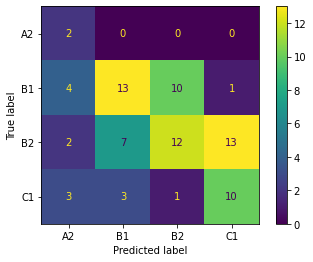

In [107]:
conf_matrix(y_test, y_preds2, estimator2.classes_)

После проверки двух моделей CBC и TfidfVectorizer мы выбираем CBC. Её мы в дальнейшеим имплеметнируем через Streamlit, ссылка на который будет в конце вывода. 

In [141]:
with open("D:/workplace/data_science/jupyter/projects/english_skillz/catboost_clf.pcl", 'wb') as fid:
    joblib.dump(catboost_model, fid)